In [2]:
import numpy as np
import sys
import pandas as pd
import plotly.graph_objects as go
from tqdm.notebook import tqdm
from sklearn.model_selection import RepeatedKFold
#import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
#url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'
#df  = pd.read_csv(url, header=None)

In [2]:
pip install libomp

Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement libomp (from versions: none)
ERROR: No matching distribution found for libomp
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'
df  = pd.read_csv("processed.cleveland.data", header=None)
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0,1
299,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2.0,7.0,2
300,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.0,7.0,3
301,57.0,0.0,2.0,130.0,236.0,0.0,2.0,174.0,0.0,0.0,2.0,1.0,3.0,1


In [4]:
for i in range(13):
    df[i] = df[i].apply(lambda x: np.nan if x=='?' else x)
    df[i] = df[i].astype(float)
df = df.dropna()

In [5]:
def binarize(x):
    if x==0:
        value=0
    else:
        value=1
    return value
df[13] = df[13].map(binarize)


/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [6]:
X = df.drop(13, axis=1)
y = df[13]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101, stratify=y)

In [8]:
cv    = RepeatedKFold(n_splits=5, n_repeats=100, random_state=101)
folds = [(train,test) for train, test in cv.split(X_train, y_train)]

In [ ]:
metrics = ['auc', 'fpr', 'tpr', 'thresholds']
results = {
    'train': {m:[] for m in metrics},
    'val'  : {m:[] for m in metrics},
    'test' : {m:[] for m in metrics}
}

In [ ]:
params = {
    'objective'   : 'binary:logistic',
    'eval_metric' : 'logloss'
}

In [1]:
dtest = xgb.DMatrix(X_test, label=y_test)
for train, test in tqdm(folds, total=len(folds)):
    dtrain = xgb.DMatrix(X_train.iloc[train,:], label=y_train.iloc[train])
    dval   = xgb.DMatrix(X_train.iloc[test,:], label=y_train.iloc[test])
    model  = xgb.train(
        dtrain                = dtrain,
        params                = params, 
        evals                 = [(dtrain, 'train'), (dval, 'val')],
        num_boost_round       = 1000,
        verbose_eval          = False,
        early_stopping_rounds = 10,
    )
    sets = [dtrain, dval, dtest]
    for i,ds in enumerate(results.keys()):
        y_preds              = model.predict(sets[i])
        labels               = sets[i].get_label()
        fpr, tpr, thresholds = roc_curve(labels, y_preds)
        results[ds]['fpr'].append(fpr)
        results[ds]['tpr'].append(tpr)
        results[ds]['thresholds'].append(thresholds)
        results[ds]['auc'].append(roc_auc_score(labels, y_preds))

NameError: name 'xgb' is not defined

In [4]:
predData = pd.read_csv("predictionsDfVec.csv")
predData

,Unnamed: 0,folds,predictedLabel,actualLabel
0,3,1,0.681455,1
1,12,1,0.999085,1
2,21,1,0.999920,1
3,56,1,0.710845,1
4,61,1,0.943665,1
...,...,...,...,...
1365,1649,5,0.482779,0
1366,1659,5,0.249290,0
1367,1669,5,0.240768,0
1368,1709,5,0.019647,0


/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:15: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  from ipykernel import kernelapp as app
/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:15: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  from ipykernel import kernelapp as app
/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:15: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  from ipykernel import kernelapp as app
/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:15: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  from ipykernel import kernelapp as app
/Users/meemansasood/Library/Python/3.7/lib/p

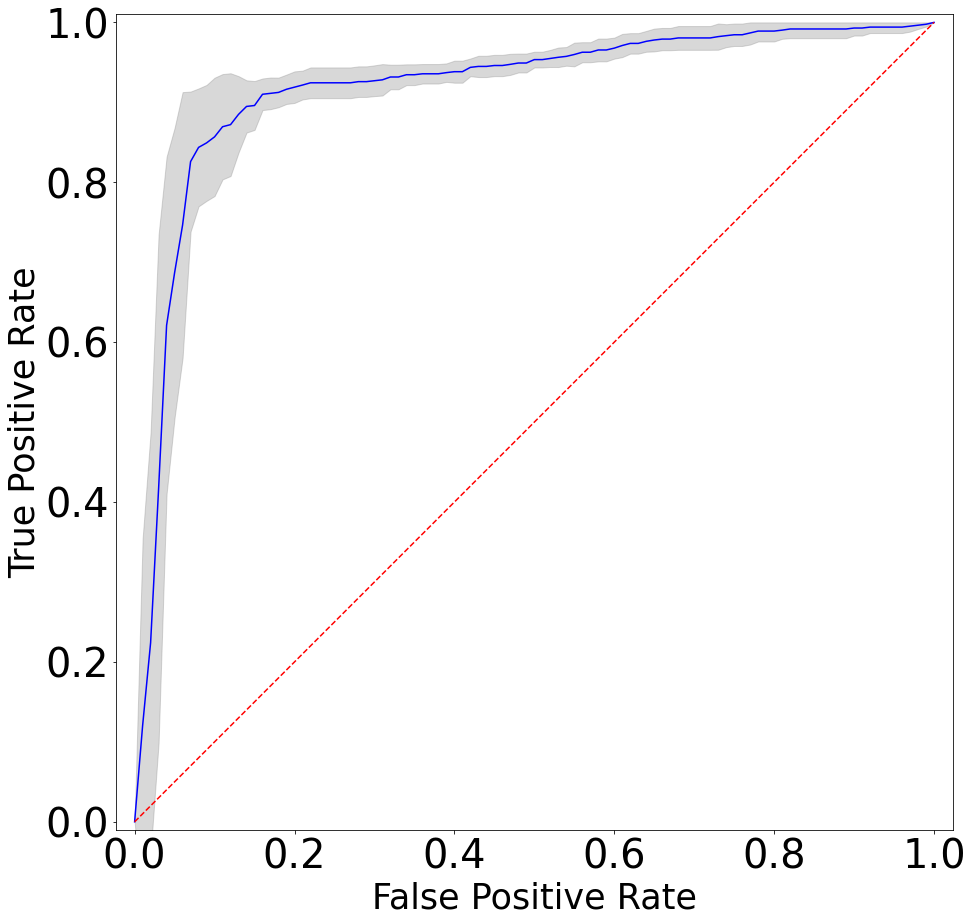

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import interp
from sklearn.metrics import roc_curve

tprs = []
base_fpr = np.linspace(0, 1, 101)

plt.figure(figsize=(15, 15))

for fold in predData.folds.unique():
    df_s = predData.loc[predData.folds == fold]
    fpr, tpr, _ = roc_curve(df_s.actualLabel, df_s.predictedLabel)
    #plt.plot(fpr, tpr, 'b', alpha=0.15)
    tpr = interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs.append(tpr)

tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std

base_fpr, mean_tprs
plt.plot(base_fpr, mean_tprs, 'b')
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)#

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.01])#
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate', fontsize = 35)
plt.xlabel('False Positive Rate', fontsize = 35)
plt.axes().set_aspect('equal', 'datalim')
plt.xticks(fontsize = 35)
plt.yticks(fontsize = 35)
plt.show()


In [10]:
tprs

array([[0.        , 0.6875    , 0.6875    , ..., 1.        , 1.        ,
        1.        ],
       [0.        , 0.06666667, 0.06666667, ..., 1.        , 1.        ,
        1.        ],
       [0.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       ...,
       [0.        , 0.93333333, 0.93333333, ..., 1.        , 1.        ,
        1.        ],
       [0.        , 0.52941176, 0.52941176, ..., 1.        , 1.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        1.        ]])

In [8]:
base_fpr

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])